# 动手实践

## 初始化算法

载入一些必备的库：

In [1]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
#set_matplotlib_formats('svg', 'pdf')

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.datasets import make_moons

save_dir = '../data/images'

## 创建一个简单的数据集

利用 `make_moons` 生成一个半月形数据集。

In [56]:
n = 800   # 样本数
n_labeled = 10 # 有标签样本数
X, Y = make_moons(n, shuffle=True, noise=0.1, random_state=1000)

X.shape, Y.shape

((800, 2), (800,))

In [3]:
def one_hot(Y, n_classes):
    '''
    对标签做 one_hot 编码
    
    参数
    =====
    Y: 从 0 开始的标签
    n_classes: 类别数
    '''
    out = Y[:, None] == np.arange(n_classes)
    return out.astype(float)

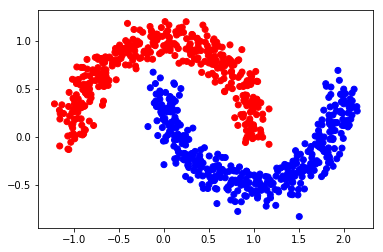

In [4]:
color = ['red' if l == 0 else 'blue' for l in Y]
plt.scatter(X[:, 0], X[:, 1], color=color)
plt.savefig(f"{save_dir}/bi_classification.pdf", format='pdf')
plt.show()

Y_input = np.concatenate((one_hot(Y[:n_labeled], 2), np.zeros((n-n_labeled, 2))))

## 算法过程：

### Step 1: 创建相似度矩阵 W

In [5]:
def rbf(x, sigma):
    return np.exp((-x)/(2* sigma**2))

In [6]:
sigma = 0.2
dm = cdist(X, X, 'euclidean')
W = rbf(dm, sigma)
np.fill_diagonal(W, 0)   # 对角线全为 0

### Step 2: 计算 S

$$
S = D^{-\frac{1}{2}} W D^{-\frac{1}{2}}
$$

向量化编程：

In [7]:
def calculate_S(W):
    d = np.sum(W, axis=1) 
    D_ = np.sqrt(d*d[:, np.newaxis]) # D_ 是 np.sqrt(np.dot(diag(D),diag(D)^T))
    return np.divide(W, D_, where=D_ != 0)


S = calculate_S(W)

### 迭代一次的结果

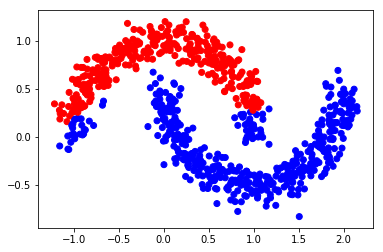

In [8]:
alpha = 0.99
F = np.dot(S, Y_input)*alpha + (1-alpha)*Y_input

Y_result = np.zeros_like(F)
Y_result[np.arange(len(F)), F.argmax(1)] = 1

Y_v = [1 if x == 0 else 0 for x in Y_result[0:,0]]

color = ['red' if l == 0 else 'blue' for l in Y_v]
plt.scatter(X[0:,0], X[0:,1], color=color)
#plt.savefig("iter_1.pdf", format='pdf')
plt.show()

### Step 3: 迭代  F "n_iter" 次直到收敛

In [9]:
n_iter = 150
F = Y_input
for t in range(n_iter):
    F = np.dot(S, F)*alpha + (1-alpha)*Y_input

### Step 4:  画出最终结果

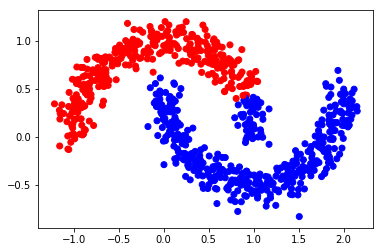

In [10]:
Y_result = np.zeros_like(F)
Y_result[np.arange(len(F)), F.argmax(1)] = 1

Y_v = [1 if x == 0 else 0 for x in Y_result[0:,0]]

color = ['red' if l == 0 else 'blue' for l in Y_v]
plt.scatter(X[0:,0], X[0:,1], color=color)
#plt.savefig("iter_n.pdf", format='pdf')
plt.show()

In [11]:
from sklearn import metrics

print(metrics.classification_report(Y, F.argmax(1)))

acc = metrics.accuracy_score(Y, F.argmax(1))
print('准确度为',acc)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92       400
           1       0.88      1.00      0.93       400

   micro avg       0.93      0.93      0.93       800
   macro avg       0.94      0.93      0.93       800
weighted avg       0.94      0.93      0.93       800

准确度为 0.92875


## sklearn 实现 lgc

参考：https://scikit-learn.org/stable/modules/label_propagation.html

在 sklearn 里提供了两个 lgc 模型：`LabelPropagation` 和 `LabelSpreading`，其中后者是前者的正则化形式。$W$ 的计算方式提供了 `rbf` 与 `knn`。

- `rbf` 核由参数 `gamma`控制（$\gamma=\frac{1}{2{\sigma}^2}$）
- `knn` 核 由参数 `n_neighbors`（近邻数）控制

In [12]:
def pred_lgc(X, Y, F, numLabels):
    from sklearn import preprocessing 
    from sklearn.semi_supervised import LabelSpreading
    cls = LabelSpreading(max_iter=150, kernel='rbf', gamma=0.003, alpha=.99)
    # X.astype(float) 为了防止报错 "Numerical issues were encountered "
    cls.fit(preprocessing.scale(X.astype(float)), F)
    ind_unlabeled = np.arange(numLabels, len(X))
    y_pred = cls.transduction_[ind_unlabeled]
    y_true = Y[numLabels:].astype(y_pred.dtype)
    return y_true, y_pred

In [13]:
Y_input = np.concatenate((Y[:n_labeled], -np.ones(n-n_labeled)))
y_true, y_pred = pred_lgc(X, Y, Y_input, n_labeled)
print(metrics.classification_report(Y, F.argmax(1)))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92       400
           1       0.88      1.00      0.93       400

   micro avg       0.93      0.93      0.93       800
   macro avg       0.94      0.93      0.93       800
weighted avg       0.94      0.93      0.93       800



# networkx 实现 lgc

先谈谈 networkx 的 graph 与其他数据格式转换（参考：https://www.cnblogs.com/wushaogui/p/9240941.html） ：

## 从字典生成图 

In [14]:
import networkx as nx
from networkx.algorithms import node_classification

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


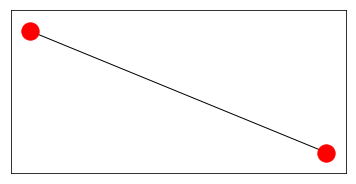

{0: {1: {'weight': 1}}, 1: {0: {'weight': 1}}}


In [15]:
dod = {0: {1: {'weight': 1}}}   
G = nx.from_dict_of_dicts(dod)  #或G=nx.Graph(dpl) 
plt.subplots(1,1,figsize=(6,3)) 
nx.draw(G) 
plt.axis('on') 
plt.xticks([]) 
plt.yticks([]) 
plt.show() 
 
#图转换为字典 
print(nx.to_dict_of_dicts(G))

## 从列表中创建graph

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


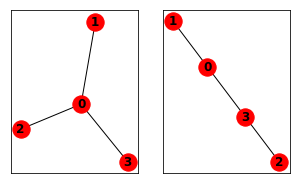

{0: [1, 2, 3], 1: [0], 2: [0], 3: [0]}
[(0, 1, {}), (0, 2, {}), (0, 3, {})]


In [16]:
dol = {0: [1, 2, 3]}
edgelist = [(0, 1), (0, 3), (2, 3)]

G1 = nx.from_dict_of_lists(dol)  # 或G=nx.Graph(dol)
G2 = nx.from_edgelist(edgelist)

# 显示graph
plt.subplots(1, 2, figsize=(5, 3))
plt.subplot(121)
nx.draw(G1, with_labels=True, font_weight='bold')
plt.axis('on')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
nx.draw(G2, with_labels=True, font_weight='bold')
plt.axis('on')
plt.xticks([])
plt.yticks([])
plt.show()

# graph转list
print(nx.to_dict_of_lists(G1))
print(nx.to_edgelist(G1))

## graph 与 numpy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  app.launch_new_instance()


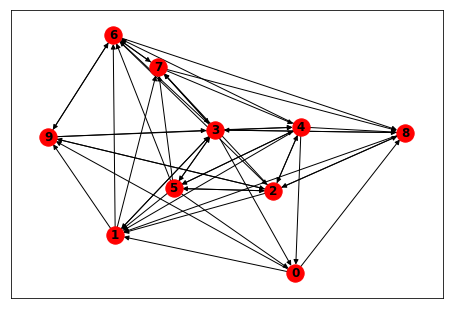

[[0. 7.]
 [7. 0.]] [[(0., 0) (7., 5)]
 [(7., 5) (0., 0)]]


In [17]:
#从numpy创建graph 
import numpy as np 
a = np.reshape(np.random.random_integers(0, 1, size=100), (10, 10)) 
D = nx.DiGraph(a) 
nx.draw(D, with_labels=True, font_weight='bold') 
plt.axis('on') 
plt.xticks([]) 
plt.yticks([]) 
plt.show() 
 
#graph返回numpy 
G=nx.Graph() 
G.add_edge(1, 2, weight=7.0, cost=5) 
A1 = nx.to_numpy_matrix(G) 
A2 = nx.to_numpy_recarray(G, dtype=[('weight', float), ('cost', int)]) 
print(A1,A2) 

## 从 scipy 创建 graph 

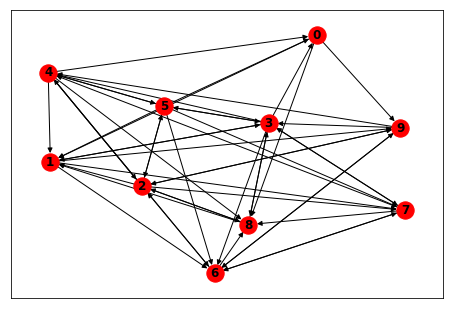

[[0. 1.]
 [1. 0.]]


In [18]:
#从scipy创建graph 
G.clear() 
import scipy as sp 
A = sp.sparse.eye(2, 2, 1) 
G = nx.from_scipy_sparse_matrix(A) 
nx.draw(D, with_labels=True, font_weight='bold') 
plt.axis('on') 
plt.xticks([]) 
plt.yticks([]) 
plt.show() 
 
#graph返回scipy 
A = nx.to_scipy_sparse_matrix(G) 
print(A.todense())

## graph 与 Pandas

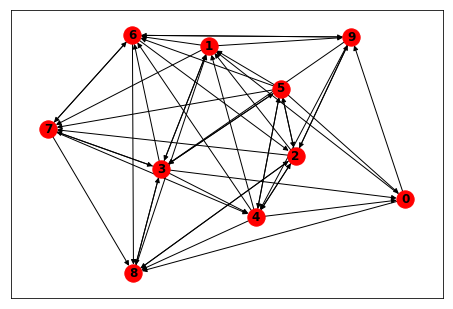

     0    1
0  1.0  2.0
1  2.0  1.0


In [19]:
#从pandas创建graph 
G.clear() 
import pandas as pd 
df = pd.DataFrame([[1, 1], [2, 1]]) 
G = nx.from_pandas_adjacency(df) 
nx.draw(D, with_labels=True, font_weight='bold') 
plt.axis('on') 
plt.xticks([]) 
plt.yticks([]) 
plt.show() 
 
#graph返回scipy 
df = nx.to_pandas_adjacency(G)
print(df)

In [20]:
G = nx.path_graph(4)
G.node[0]['label'] = 'A'
G.node[3]['label'] = 'B'
G.nodes(data=True)

G.edges()

predicted = node_classification.local_and_global_consistency(G)
predicted

['A', 'A', 'B', 'B']